# Deep Learning for Market Movement Prediction

In [85]:
# SETTINGS
import os
import sys

# get the current working directory
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

# change the working directory to the project directory
proj_directory = 'C:\Repos\quant-trading-suite'

# add root directory of project to the sys.path
sys.path.append('C:\\Repos\\quant-trading-suite')

try:
    os.chdir(proj_directory)
    print(f"Changed to: {proj_directory}")
except FileNotFoundError:
    print(f"Directory not found: {proj_directory}")

    
#os.listdir()

Current Working Directory: C:\Repos\quant-trading-suite
Changed to: C:\Repos\quant-trading-suite


In [86]:
# Import libraries
import pandas as pd
import numpy as np
from plotly import graph_objects as go
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from keras.models import Sequential         # Model type
from keras.layers import Dense              # Layers  
from keras.optimizers import Adam, RMSprop  # Optimizers
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
# Import functions
from scripts.data_download import get_bybit_data

## Data Preparation

### Import Data

In [88]:
# IMPORT DATA

symbol = 'BTCUSDT'
start_time = '2023-01-01 00:00:00'

raw_data = get_bybit_data(product_type='linear', symbol=symbol, interval=60,
                      start_time=start_time,
                      verbose=False)

raw_data.head()

,Time,Open,High,Low,Close,Volume
0,2023-01-01 00:00:00,16549.5,16556.0,16524.0,16545.0,1202.025
1,2023-01-01 01:00:00,16545.0,16570.0,16544.0,16570.0,620.348
2,2023-01-01 02:00:00,16570.0,16577.5,16562.0,16563.5,774.636
3,2023-01-01 03:00:00,16563.5,16564.0,16540.5,16553.0,798.486
4,2023-01-01 04:00:00,16553.0,16553.0,16529.0,16534.5,704.972


<IPython.core.display.Javascript object>


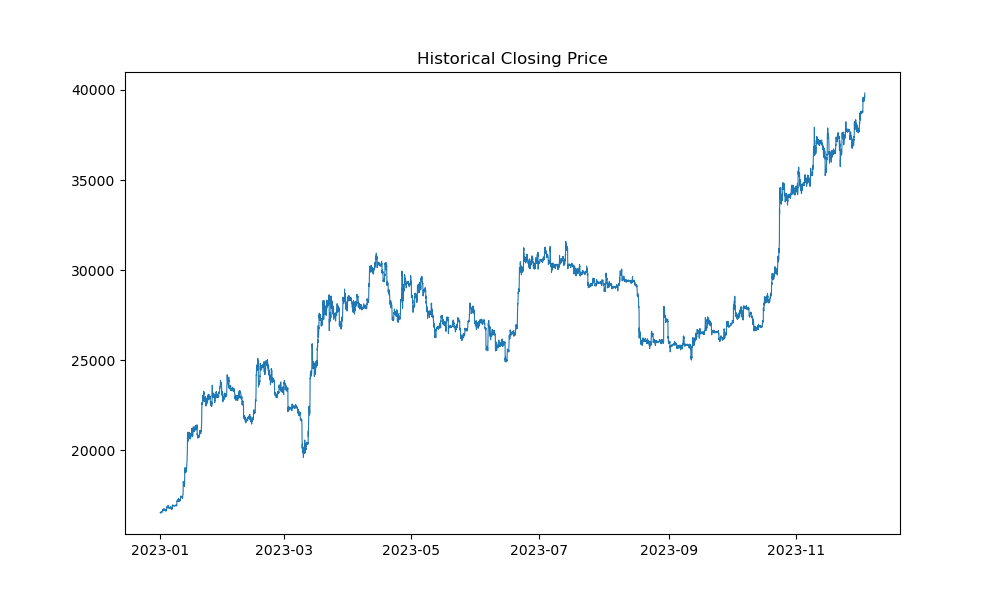

In [89]:
# PLOT DATA

# create the figure and axes
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(pd.to_datetime(raw_data['Time']), raw_data['Close'], lw=0.8)
ax.set_title(f'{symbol} Historical Closing Price')
plt.show()

### Calculate returns (Target variable)

In [90]:
# Calculate the discrete returns and define the direction as a binary column
data = raw_data.copy()

data['return'] = data['Close']/data['Close'].shift(1) - 1

data['direction'] = np.where(data['return'] > 0, 1, 0)

data.head()

,Time,Open,High,Low,Close,Volume,return,direction
0,2023-01-01 00:00:00,16549.5,16556.0,16524.0,16545.0,1202.025,NaN,0
1,2023-01-01 01:00:00,16545.0,16570.0,16544.0,16570.0,620.348,0.001511,1
2,2023-01-01 02:00:00,16570.0,16577.5,16562.0,16563.5,774.636,-0.000392,0
3,2023-01-01 03:00:00,16563.5,16564.0,16540.5,16553.0,798.486,-0.000634,0
4,2023-01-01 04:00:00,16553.0,16553.0,16529.0,16534.5,704.972,-0.001118,0


### Create Features

In [91]:
# Create the lagged data
lags = 5

features = []
for lag in range(1, lags + 1):
    feature = f'lag_{lag}'
    data[feature] = data['return'].shift(lag)
    features.append(feature)
    
data.round(4).head()

,Time,Open,High,Low,Close,Volume,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
0,2023-01-01 00:00:00,16549.5,16556.0,16524.0,16545.0,1202.025,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 01:00:00,16545.0,16570.0,16544.0,16570.0,620.348,0.0015,1,NaN,NaN,NaN,NaN,NaN
2,2023-01-01 02:00:00,16570.0,16577.5,16562.0,16563.5,774.636,-0.0004,0,0.0015,NaN,NaN,NaN,NaN
3,2023-01-01 03:00:00,16563.5,16564.0,16540.5,16553.0,798.486,-0.0006,0,-0.0004,0.0015,NaN,NaN,NaN
4,2023-01-01 04:00:00,16553.0,16553.0,16529.0,16534.5,704.972,-0.0011,0,-0.0006,-0.0004,0.0015,NaN,NaN


In [92]:
# Additional Features
data['momentum'] = data['return'].rolling(5).mean().shift(1) # average return over the last 5 hours

data['volatility'] = data['return'].rolling(20).std().shift(1) # the standard deviation of returns over the last 20 hours

data['distance'] = (data['Close'] / data['Close'].rolling(50).mean() - 1).shift(1) # consider changing to percentage distance

data.round(4).tail()

,Time,Open,High,Low,Close,Volume,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
8076,2023-12-03 12:00:00,39496.0,39523.9,39380.8,39415.0,2317.474,-0.0021,0,-0.0013,0.0020,0.0016,-0.0020,0.0017,0.0004,0.0038,0.0137
8077,2023-12-03 13:00:00,39415.0,39812.4,39400.0,39688.1,10861.043,0.0069,1,-0.0021,-0.0013,0.0020,0.0016,-0.0020,-0.0004,0.0038,0.0111
8078,2023-12-03 14:00:00,39688.1,39770.5,39552.0,39554.7,5626.570,-0.0034,0,0.0069,-0.0021,-0.0013,0.0020,0.0016,0.0014,0.0041,0.0176
8079,2023-12-03 15:00:00,39554.7,39836.3,39492.1,39786.1,6606.941,0.0059,1,-0.0034,0.0069,-0.0021,-0.0013,0.0020,0.0004,0.0042,0.0135
8080,2023-12-03 16:00:00,39786.1,39834.0,39774.4,39832.1,330.883,0.0012,1,0.0059,-0.0034,0.0069,-0.0021,-0.0013,0.0012,0.0030,0.0187


<Axes: >

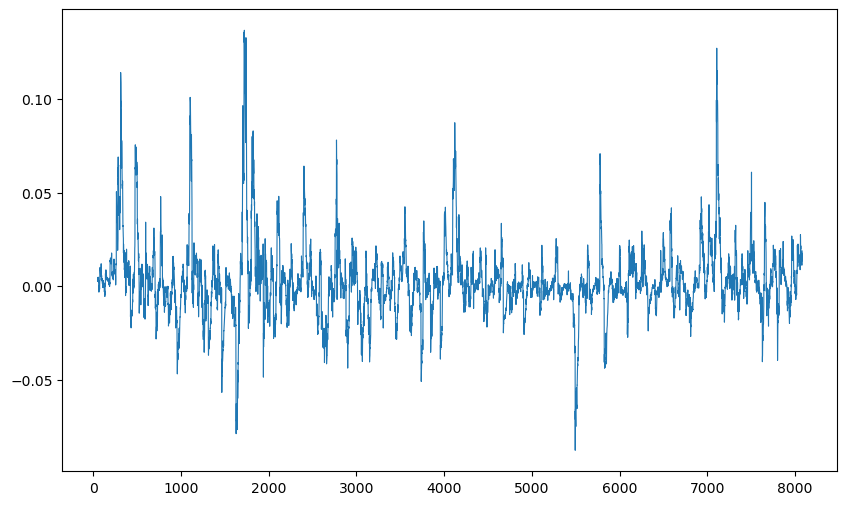

In [96]:
%matplotlib inline
data['distance'].plot(figsize=(10,6), lw=0.8)

In [97]:
# Delete rows containing NaN values
data.dropna(inplace=True) # should we reset the index?
data.round(4).head()

,Time,Open,High,Low,Close,Volume,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
50,2023-01-03 02:00:00,16677.0,16683.5,16671.0,16674.5,811.217,-0.0001,0,-0.0011,0.0017,-0.0016,-0.0034,0.0014,-0.0006,0.0017,0.0027
51,2023-01-03 03:00:00,16674.5,16697.5,16669.5,16691.0,1038.234,0.0010,1,-0.0001,-0.0011,0.0017,-0.0016,-0.0034,-0.0009,0.0017,0.0024
52,2023-01-03 04:00:00,16691.0,16699.5,16684.0,16689.0,882.500,-0.0001,0,0.0010,-0.0001,-0.0011,0.0017,-0.0016,-0.0000,0.0013,0.0033
53,2023-01-03 05:00:00,16689.0,16722.0,16686.5,16719.5,2371.107,0.0018,1,-0.0001,0.0010,-0.0001,-0.0011,0.0017,0.0003,0.0013,0.0030
54,2023-01-03 06:00:00,16719.5,16774.0,16716.5,16719.0,5857.101,-0.0000,0,0.0018,-0.0001,0.0010,-0.0001,-0.0011,0.0003,0.0014,0.0046


### Training and Test Data Sets

In [98]:
size = len(data)

test_size = 24*30     # 30 Days
train_size = size - test_size

print(f"Data size: {size}")
print(f"Train data size: {train_size}")
print(f"Test data size: {test_size}")

Data size: 8031
Train data size: 7311
Test data size: 720


In [110]:
# dataset columns
cols = features.copy()
cols.append('direction')

dataset = data[cols] # Leave the return column in this dataset as it will be required later.
dataset.reset_index(inplace=True, drop=True)
dataset.round(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
0,-0.0011,0.0017,-0.0016,-0.0034,0.0014,0
1,-0.0001,-0.0011,0.0017,-0.0016,-0.0034,1
2,0.0010,-0.0001,-0.0011,0.0017,-0.0016,0
3,-0.0001,0.0010,-0.0001,-0.0011,0.0017,1
4,0.0018,-0.0001,0.0010,-0.0001,-0.0011,0
...,...,...,...,...,...,...
8026,-0.0013,0.0020,0.0016,-0.0020,0.0017,0
8027,-0.0021,-0.0013,0.0020,0.0016,-0.0020,1
8028,0.0069,-0.0021,-0.0013,0.0020,0.0016,0
8029,-0.0034,0.0069,-0.0021,-0.0013,0.0020,1


In [111]:
# Training Dataset
training_data = dataset[:train_size].copy()
print(f"Train data size: {len(training_data)}")
training_data.round(4)

Train data size: 7311


,lag_1,lag_2,lag_3,lag_4,lag_5,direction
0,-0.0011,0.0017,-0.0016,-0.0034,0.0014,0
1,-0.0001,-0.0011,0.0017,-0.0016,-0.0034,1
2,0.0010,-0.0001,-0.0011,0.0017,-0.0016,0
3,-0.0001,0.0010,-0.0001,-0.0011,0.0017,1
4,0.0018,-0.0001,0.0010,-0.0001,-0.0011,0
...,...,...,...,...,...,...
7306,-0.0006,0.0008,-0.0049,-0.0011,0.0007,1
7307,0.0041,-0.0006,0.0008,-0.0049,-0.0011,1
7308,0.0051,0.0041,-0.0006,0.0008,-0.0049,1
7309,0.0041,0.0051,0.0041,-0.0006,0.0008,1


In [112]:
# Test Dataset
test_data = dataset[train_size:(train_size+test_size)].copy()
print(f"Test data size: {len(test_data)}")
test_data.round(4)

Test data size: 720


,lag_1,lag_2,lag_3,lag_4,lag_5,direction
7311,-0.0027,0.0013,0.0041,0.0051,0.0041,0
7312,-0.0071,-0.0027,0.0013,0.0041,0.0051,1
7313,0.0030,-0.0071,-0.0027,0.0013,0.0041,0
7314,0.0000,0.0030,-0.0071,-0.0027,0.0013,1
7315,0.0019,0.0000,0.0030,-0.0071,-0.0027,1
...,...,...,...,...,...,...
8026,-0.0013,0.0020,0.0016,-0.0020,0.0017,0
8027,-0.0021,-0.0013,0.0020,0.0016,-0.0020,1
8028,0.0069,-0.0021,-0.0013,0.0020,0.0016,0
8029,-0.0034,0.0069,-0.0021,-0.0013,0.0020,1


In [113]:
# Standardize the datasets
mu, std = training_data.mean(), training_data.std()

training_data_ = (training_data - mu)/std

training_data_.round(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
0,-0.2688,0.3375,-0.3717,-0.7556,0.2788,-1.0239
1,-0.0562,-0.2688,0.3377,-0.3715,-0.7556,0.9765
2,0.1890,-0.0562,-0.2686,0.3379,-0.3714,-1.0239
3,-0.0497,0.1890,-0.0560,-0.2684,0.3380,0.9765
4,0.3693,-0.0497,0.1891,-0.0558,-0.2683,-1.0239
...,...,...,...,...,...,...
7306,-0.1582,0.1544,-1.0861,-0.2563,0.1165,0.9765
7307,0.8626,-0.1582,0.1546,-1.0858,-0.2563,0.9765
7308,1.0697,0.8626,-0.1580,0.1548,-1.0858,0.9765
7309,0.8507,1.0696,0.8628,-0.1578,0.1549,0.9765


In [115]:
# Standardize the test dataset
test_data_ = (test_data - mu)/std

test_data_.round(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
7311,-0.5944,0.2536,0.8509,1.0701,0.8632,-1.0239
7312,-1.5613,-0.5944,0.2538,0.8512,1.0703,0.9765
7313,0.6247,-1.5613,-0.5943,0.2541,0.8513,-1.0239
7314,-0.0239,0.6247,-1.5612,-0.5941,0.2542,0.9765
7315,0.3879,-0.0239,0.6249,-1.5610,-0.5940,0.9765
...,...,...,...,...,...,...
8026,-0.3128,0.4007,0.3268,-0.4594,0.3412,-1.0239
8027,-0.4651,-0.3128,0.4009,0.3270,-0.4594,0.9765
8028,1.4668,-0.4652,-0.3126,0.4011,0.3271,-1.0239
8029,-0.7471,1.4668,-0.4650,-0.3124,0.4012,0.9765


### The Model

In [22]:
# Specify the optimizer
optimizer = Adam(learning_rate=0.0001)

In [23]:
# Set seeds
def set_seeds(seed=100):
    #random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)
    
set_seeds()

In [50]:
# Specify the Model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(features),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])

# The architecture of this model includes 4 layers, the input layer, 2 layers with 64 nodes, and the output layer (?).

In [48]:
# specify several models that I will be testing (I need my approach to be extensible)

# model1 = LogisticRegression()
# model2 = GradientBoosting()
# model3 = RandomForest()
# model4 = DNN()
# model5 = LSTM()


In [55]:
%%time
# Fit the Model
model.fit(training_data_[features], 
          training_data['direction'],
         epochs=50, verbose=False,
         validation_split=0.2, shuffle=False)

CPU times: total: 19.2 s
Wall time: 13.5 s


In [60]:
y_pred = np.where(model.predict(test_data_[features]) > 0.5, 1, 0)
accuracy = accuracy_score(test_data['direction'], y_pred)
print(accuracy)

23/23 [==============================] - 0s 1ms/step
0.5083333333333333


In [118]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score

def train_logistic_regression(X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

def train_gradient_boosting(X_train, y_train):
    model = GradientBoostingClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    return model

def train_random_forest(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    return accuracy, auc, recall, precision

In [119]:

# Train and evaluate Logistic Regression
lr_model = train_logistic_regression(training_data_[features], training_data['direction'])
lr_results = evaluate_model(lr_model, test_data_[features], test_data['direction'])

# Train and evaluate Gradient Boosting
gb_model = train_gradient_boosting(training_data_[features], training_data['direction'])
gb_results = evaluate_model(gb_model, test_data_[features], test_data['direction'])

# Train and evaluate Random Forest
rf_model = train_random_forest(X_train=training_data_[features], y_train=training_data['direction'])
rf_results = evaluate_model(rf_model, X_test=test_data_[features], y_test=test_data['direction'])

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Model': ['Gradient Boosting', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [gb_results[0], rf_results[0], lr_results[0]],
    'AUC': [gb_results[1], rf_results[1], lr_results[1]],
    'Recall': [gb_results[2], rf_results[2], lr_results[2]],
    'Precision': [gb_results[3], rf_results[3], lr_results[3]]
})

print(results_df)

                 Model  Accuracy       AUC    Recall  Precision
0    Gradient Boosting  0.555556  0.571914  0.561497   0.573770
1        Random Forest  0.525000  0.537263  0.540107   0.543011
2  Logistic Regression  0.540278  0.572788  0.700535   0.544699


**What are epochs?**

**How can I easily remember what epochs are?**

<Axes: >

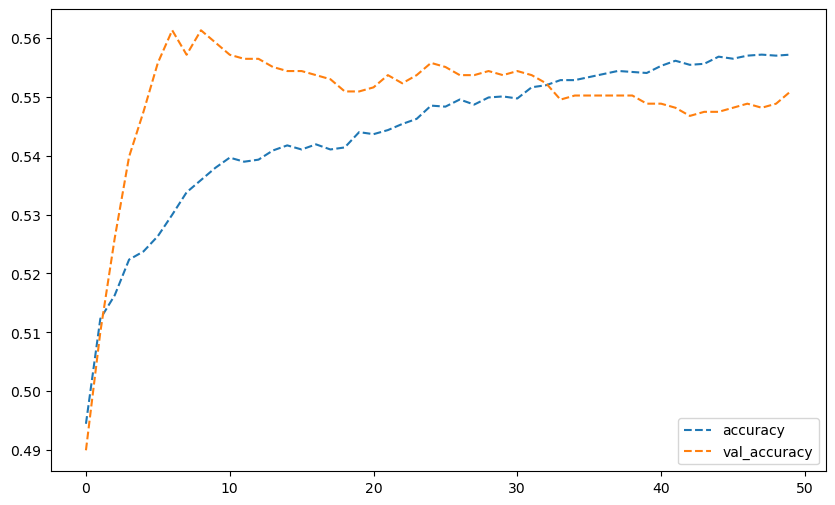

In [26]:
res = pd.DataFrame(model.history.history)

res[['accuracy', 'val_accuracy']].plot(figsize=(10,6), style='--')

In [69]:
# Evaluate model
model.evaluate(training_data_[features], training_data['direction'])

AttributeError: 'RandomForestClassifier' object has no attribute 'evaluate'

In [120]:
# PREDICTIONS

# Choose model
model = lr_model

pred = np.where(model.predict(training_data_[features]) > 0.5, 1, 0)
pred[:30].flatten()

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0])

In [121]:
# Calculate the strategy returns given the positions

training_data['prediction'] = np.where(pred > 0, 1, -1)

# add return column to training_data
training_data['return'] = data[:train_size]['return']

# strategy returns
training_data['strategy'] = (training_data['prediction'] * training_data['return'])

training_data

,lag_1,lag_2,lag_3,lag_4,lag_5,direction,prediction,return,strategy
0,-0.001138,0.001680,-0.001617,-0.003403,0.001405,0,1,NaN,NaN
1,-0.000150,-0.001138,0.001680,-0.001617,-0.003403,1,1,NaN,NaN
2,0.000990,-0.000150,-0.001138,0.001680,-0.001617,0,1,NaN,NaN
3,-0.000120,0.000990,-0.000150,-0.001138,0.001680,1,1,NaN,NaN
4,0.001828,-0.000120,0.000990,-0.000150,-0.001138,0,-1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
7306,-0.000624,0.000829,-0.004937,-0.001082,0.000650,1,1,-0.003179,-0.003179
7307,0.004120,-0.000624,0.000829,-0.004937,-0.001082,1,-1,0.001427,-0.001427
7308,0.005083,0.004120,-0.000624,0.000829,-0.004937,1,-1,0.010909,-0.010909
7309,0.004065,0.005083,0.004120,-0.000624,0.000829,1,-1,-0.006027,0.006027


In [122]:
# Total return (In-sample)
(1 + training_data[['return','strategy']]).prod()

return      2.050279
strategy    1.014779
dtype: float64

In [278]:
# Export to check in excel:


<Axes: >

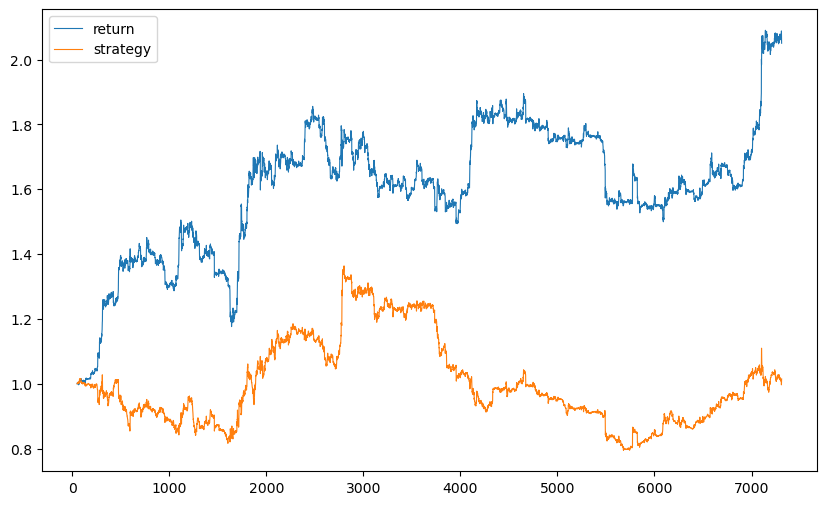

In [123]:
# Plot strategy performance (in-sample)
(1 + training_data[['return','strategy']]).cumprod().plot(figsize=(10,6), lw=0.8)

How should I evaluate the performance of my models. Should I base the evaluation on in-sample data or out-of-sample data, i.e. based on the test sets.

My intuition say test set. By I will have limited test set data, which may also be affected by the regime at the time (market regime at the time).

### Perfomance of model on Test Data (Out-of-sample)

In [81]:
# Perfomance of model on test data
model.evaluate(test_data_[features], test_data['direction'])

23/23 [==============================] - 1s 8ms/step - loss: 0.7163 - accuracy: 0.5083


[0.7162577509880066, 0.5083333253860474]

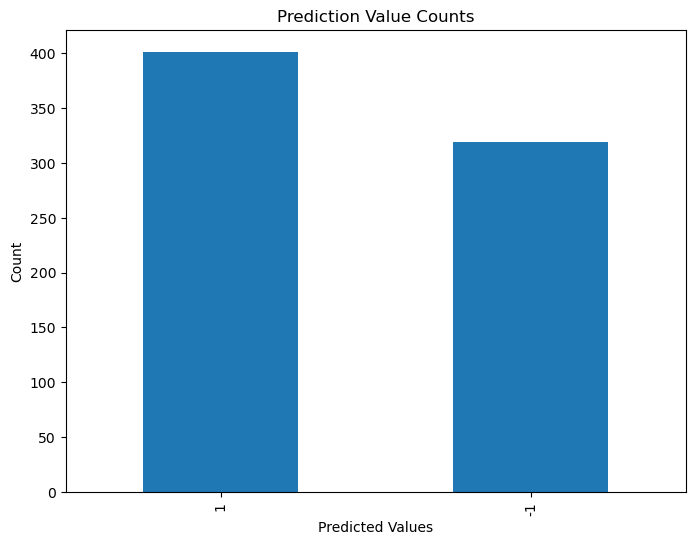

In [82]:
# Predictions
pred = np.where(gb_model.predict(test_data_[features]) > 0.5, 1, 0)

test_data['prediction'] = np.where(pred > 0 , 1, -1)

# Get the value counts
value_counts = test_data['prediction'].value_counts()

# Create a bar graph
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar')

# Add labels and a title
plt.xlabel('Predicted Values')
plt.ylabel('Count')
plt.title('Prediction Value Counts')

# Show the plot
plt.show()

In [83]:
# Add returns column
test_data['return'] = data[train_size:(train_size + test_size)]['return']

# Calculate strategy returns
test_data['strategy'] = (test_data['prediction'] * test_data['return'])

(1 + test_data[['return','strategy']]).prod()

return      1.754365
strategy    1.000021
dtype: float64

<Axes: >

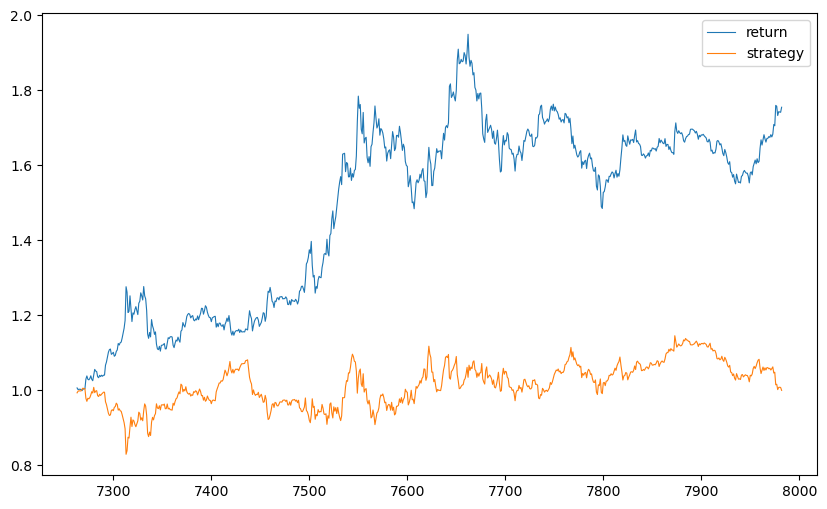

In [84]:
# Plot strategy performance
(1 + test_data[['return','strategy']]).cumprod().plot(figsize=(10,6), lw=0.8)

### Additional Features

In [36]:
# dataset columns
features.extend(['momentum', 'volatility', 'distance'])
cols = features.copy()
cols.append('direction')

dataset = data[cols].copy() # Leave the return column in this dataset as it will be required later.

dataset.dropna(inplace=True)

dataset.round(4).head()

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction
50,-0.0195,0.0022,0.0004,-0.0079,0.0022,-0.0045,0.0258,0.6868,1
51,0.0063,-0.0195,0.0022,0.0004,-0.0079,-0.0037,0.0257,0.7337,1
52,0.0063,0.0063,-0.0195,0.0022,0.0004,-0.0008,0.0069,0.7800,1
53,0.0054,0.0063,0.0063,-0.0195,0.0022,0.0001,0.0068,0.8147,1
54,0.0404,0.0054,0.0063,0.0063,-0.0195,0.0078,0.0112,1.2343,0


In [37]:
# Training Dataset
training_data = dataset[:train_size].copy()

training_data.round(4).tail()

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction
7258,0.0286,0.0396,0.0005,0.0021,-0.0085,0.0125,0.0121,2.4576,0
7259,-0.0007,0.0286,0.0396,0.0005,0.0021,0.0140,0.0121,2.3837,1
7260,0.0058,-0.0007,0.0286,0.0396,0.0005,0.0148,0.0121,2.5290,0
7261,-0.0060,0.0058,-0.0007,0.0286,0.0396,0.0135,0.0123,2.2701,0
7262,-0.0012,-0.0060,0.0058,-0.0007,0.0286,0.0053,0.0123,2.1768,1


In [38]:
# Test Dataset
test_data = dataset[train_size:(train_size+test_size)].copy()

test_data.round(4).head()

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction
7263,0.0030,-0.0012,-0.0060,0.0058,-0.0007,0.0002,0.0122,2.2185,1
7264,0.0065,0.0030,-0.0012,-0.0060,0.0058,0.0016,0.0123,2.3838,0
7265,-0.0044,0.0065,0.0030,-0.0012,-0.0060,-0.0004,0.0122,2.1677,1
7266,0.0011,-0.0044,0.0065,0.0030,-0.0012,0.0010,0.0120,2.1486,0
7267,-0.0005,0.0011,-0.0044,0.0065,0.0030,0.0012,0.0119,2.0704,1


In [39]:
# Standardize the training dataset
mu, std = training_data.mean(), training_data.std()

training_data_ = (training_data - mu)/std

training_data_.round(4).head()

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction
50,-2.0859,0.2139,0.0257,-0.8613,0.2127,-1.1082,3.8454,0.7411,0.9943
51,0.6488,-2.0860,0.2138,0.0259,-0.8614,-0.9145,3.8395,0.7980,0.9943
52,0.6446,0.6488,-2.0861,0.2140,0.0259,-0.2456,-0.2965,0.8542,0.9943
53,0.5459,0.6445,0.6487,-2.0859,0.2140,-0.0146,-0.3200,0.8963,0.9943
54,4.2566,0.5459,0.6445,0.6489,-2.0859,1.7810,0.6437,1.4052,-1.0056


In [40]:
# Standardize the test dataset
test_data_ = (test_data - mu)/std

test_data_.round(4).head()

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction
7263,0.2930,-0.1523,-0.6543,0.5911,-0.0942,-0.0074,0.8781,2.5990,0.9943
7264,0.6692,0.2929,-0.1524,-0.6541,0.5910,0.3316,0.8840,2.7995,-1.0056
7265,-0.4865,0.6691,0.2928,-0.1522,-0.6541,-0.1470,0.8744,2.5374,0.9943
7266,0.0972,-0.4866,0.6690,0.2930,-0.1522,0.1867,0.8250,2.5142,-1.0056
7267,-0.0697,0.0971,-0.4867,0.6692,0.2930,0.2234,0.7985,2.4194,0.9943


### The Model with Additional Features

In [41]:
# Specify the optimizer
optimizer = Adam(learning_rate=0.0001)

In [42]:
# Set seeds
def set_seeds(seed=100):
    #random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)
    
set_seeds()

In [43]:
# Specify the Model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(features),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [44]:
%%time
# Fit the Model
model.fit(training_data_[features], 
          training_data['direction'],
         epochs=50, verbose=False,
         validation_split=0.2, shuffle=False)

CPU times: total: 22.4 s
Wall time: 13.6 s


<Axes: >

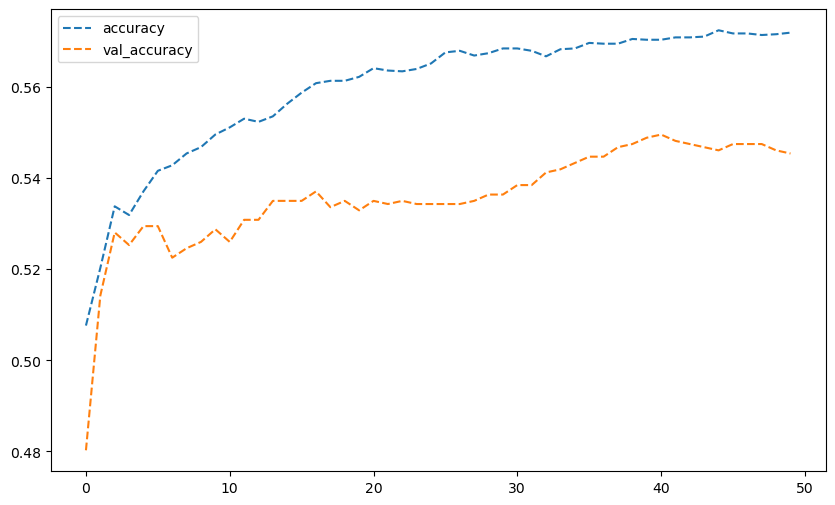

In [45]:
res = pd.DataFrame(model.history.history)

res[['accuracy', 'val_accuracy']].plot(figsize=(10,6), style='--')

In [41]:
# Evaluate model
model.evaluate(training_data_[features], training_data['direction'])

191/191 [==============================] - 0s 1ms/step - loss: 0.6748 - accuracy: 0.5743


[0.6748454570770264, 0.5743387341499329]

In [42]:
# Predictions
pred = np.where(model.predict(training_data_[features]) > 0.5, 1, 0)
pred[:30].flatten()

191/191 [==============================] - 0s 844us/step


array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1])

In [43]:
# Calculate the strategy returns given the positions

training_data['prediction'] = np.where(pred > 0, 1, -1)

# add return column to training_data
training_data['return'] = data[:train_size]['return']

# strategy returns
training_data['strategy'] = (training_data['prediction'] * training_data['return'])

training_data.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction,prediction,return,strategy
50,-0.001138,0.001680,-0.001617,-0.003403,0.001405,-0.000615,0.001692,45.25,0,1,-0.000150,-0.000150
51,-0.000150,-0.001138,0.001680,-0.001617,-0.003403,-0.000926,0.001689,40.16,1,1,0.000990,0.000990
52,0.000990,-0.000150,-0.001138,0.001680,-0.001617,-0.000047,0.001318,54.24,0,-1,-0.000120,0.000120
53,-0.000120,0.000990,-0.000150,-0.001138,0.001680,0.000252,0.001304,49.73,1,-1,0.001828,-0.001828
54,0.001828,-0.000120,0.000990,-0.000150,-0.001138,0.000282,0.001361,76.90,0,-1,-0.000030,0.000030


In [45]:
# Total return
(1 + training_data[['return','strategy']]).prod()

return      1.574840
strategy    2.725169
dtype: float64

In [298]:
# Check results in excel

<Axes: >

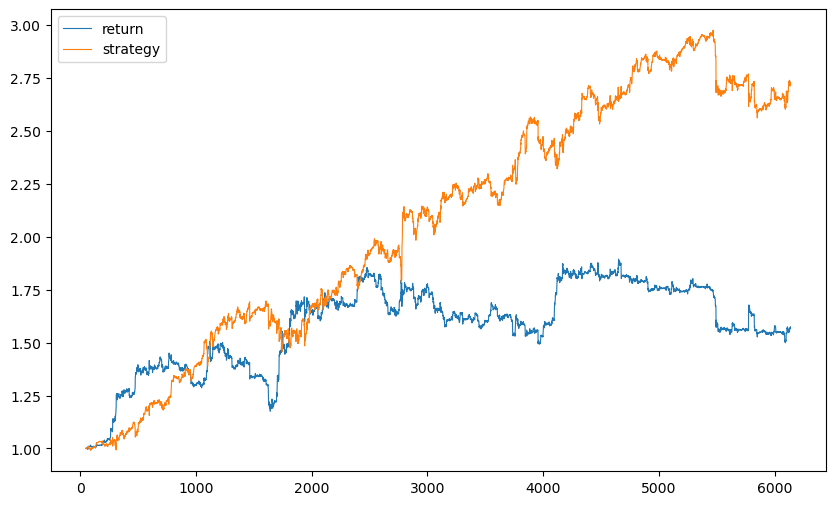

In [46]:
# Plot strategy performance (in-sample)
(1 + training_data[['return','strategy']]).cumprod().plot(figsize=(10,6), lw=0.8)

### Test Data

In [47]:
# Perfomance of model on test data
model.evaluate(test_data_[features], test_data['direction'])

23/23 [==============================] - 0s 1ms/step - loss: 0.6934 - accuracy: 0.5361


[0.6934176683425903, 0.5361111164093018]

In [48]:
# Predictions
pred = np.where(model.predict(test_data_[features]) > 0.5, 1, 0)

test_data['prediction'] = np.where(pred > 0 , 1, -1)

test_data['prediction'].value_counts()

23/23 [==============================] - 0s 1ms/step


-1    364
 1    356
Name: prediction, dtype: int64

In [49]:
# Add returns column
test_data['return'] = data[train_size:(train_size + test_size)]['return']

# Calculate strategy returns
test_data['strategy'] = (test_data['prediction'] * test_data['return'])

(1 + test_data[['return','strategy']]).prod()

return      1.019556
strategy    1.041131
dtype: float64

(array([6100., 6200., 6300., 6400., 6500., 6600., 6700., 6800., 6900.]),
 [Text(6100.0, 0, '6100'),
  Text(6200.0, 0, '6200'),
  Text(6300.0, 0, '6300'),
  Text(6400.0, 0, '6400'),
  Text(6500.0, 0, '6500'),
  Text(6600.0, 0, '6600'),
  Text(6700.0, 0, '6700'),
  Text(6800.0, 0, '6800'),
  Text(6900.0, 0, '6900')])

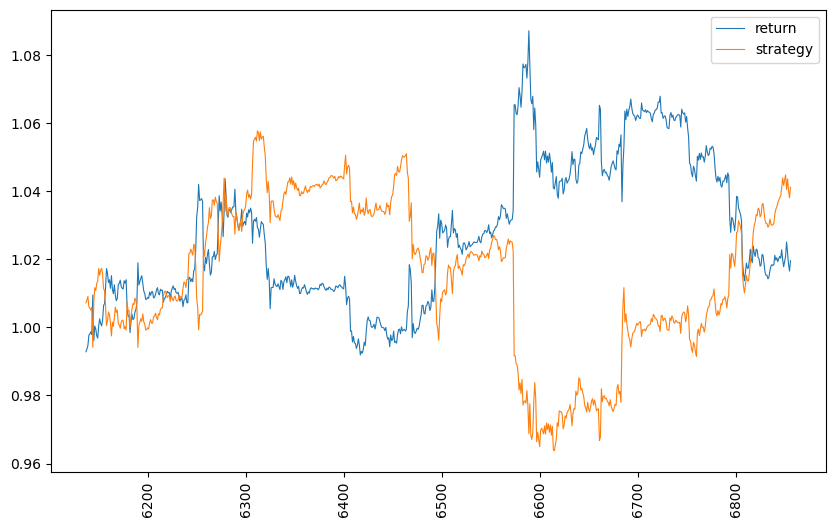

In [50]:
import matplotlib.pyplot as plt

# Plot strategy performance
(1 + test_data[['return','strategy']]).cumprod().plot(figsize=(10,6), lw=0.8)
plt.xticks(rotation=90)

With the additional features, the model strategy still out performs the buy and hold strategy, but the performance is worse than the model where only the lag features are used.

The additional features of momentum, distance and volatility do not produce alpha over the core features.

(array([2000., 2100., 2200., 2300., 2400., 2500., 2600.]),
 [Text(2000.0, 0, '2000'),
  Text(2100.0, 0, '2100'),
  Text(2200.0, 0, '2200'),
  Text(2300.0, 0, '2300'),
  Text(2400.0, 0, '2400'),
  Text(2500.0, 0, '2500'),
  Text(2600.0, 0, '2600')])

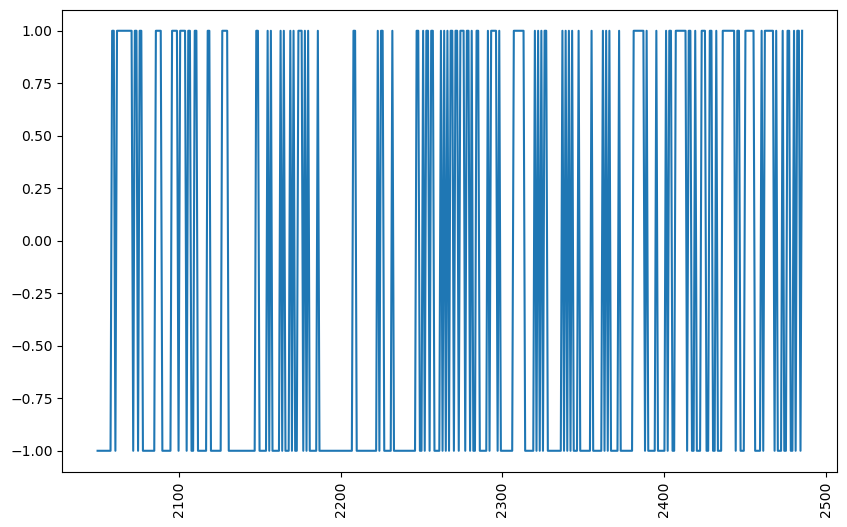

In [72]:
# Plot Positions:
test_data['prediction'].plot(figsize=(10,6))
plt.xticks(rotation=90)